# Signatures of selection on trees

This notebook shows how to use jungle to perform an analysis of the signatures of selection on trees. This involves the following steps.

1. Load trees.
2. Simulate ensembles of trees assuming evolutionary models, such as neutral drift and positive selection.
3. Calculate signatures of selection on the empirical and simulated trees.
4. Plot signatures of selection.
5. Calculate probability of observing empirical trees under the models.

# Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import ete3

# Trees cannot be rendered without an X backend
# Virtual X backend solves this problem.
# To use this, install xvfb and run jupyter notebook/lab in the xvfb environment.
# apt get xvfb
# xvfb-run jupyter 

In [2]:
sys.path.append("../../jungle/") # specify path to jungle
import jungle as jg

# Load empirical trees

We load two trees. One, called neutral, was generated by a model of neutral drift, called the Kingman coalescent. The other one called, positive selection, was generated by a model of positive selection, called the Bolthausen-Sznitman coalescent.

In [3]:
# Load trees from Newick files
infiles = ["Tree_neutral.nwk", "Tree_positive_selection.nwk"]
F_empirical = jg.Forest.from_newick(infiles)

print len(F_empirical), "trees"
print

2 trees



In [4]:
# Show size of trees
print "Size of trees:"
for tree in F_empirical.trees:
    print len(tree), "leaves"

Size of trees:
500 leaves
500 leaves


# Simulate ensembles of trees under models

The metrics used to characterize selection ("signatures of selection") vary depending on the size (number of leaves) of a tree. To evaluate whether the signatures we observe are consistent with models, such as neutral drift or positive selection, we must compare the metrics against simulated ensembles of trees which are the same size as the empirical tree. Here we generate such size-matched ensembles.

In [5]:
n_trees = 100  # number of trees in each ensemble

In [6]:
%%time

# Neutral drift (Kingman coalescent)

J_kingman = []  # list of size-matched forests for each tree

for tree in F_empirical.trees:
    n_leaves = len(tree)  # number of leaves in tree
    F_kingman = jg.Forest.generate(n_trees=n_trees, name="kingman", params={"n_leaves": n_leaves, "alpha": 2.0})
    F_kingman.rescale(total_branch_length=tree.total_branch_length())  # rescale branch length to match experimental tree
    J_kingman.append(F_kingman)

CPU times: user 15.4 s, sys: 314 ms, total: 15.7 s
Wall time: 15.7 s


In [7]:
%%time

# Positive selection (Bolthausen-Sznitman coalescent)

J_bsc = []  # list of size-matched forests for each tree

for tree in F_empirical.trees:
    n_leaves = len(tree)  # number of leaves in tree
    F_bsc = jg.Forest.generate(n_trees=n_trees, name="bsc", params={"n_leaves": n_leaves, "alpha": 1.0})
    F_bsc.rescale(total_branch_length=tree.total_branch_length())  # rescale branch length to match experimental tree
    J_bsc.append(F_bsc)

CPU times: user 8.66 s, sys: 148 ms, total: 8.8 s
Wall time: 8.81 s


# Calculate signatures of selection

We calculate several signatures of selection, named Fay and Wu's H, Zeng's E, Tajima's D, and Ferretti's L. All of these metrics are essentially ways to summarize the site frequency spectrum, so we need to calculate that first.

We calculate these signatures for the empirical trees, then the simulated size-matched trees.

In [8]:
%%time

# Empirical trees

F_empirical.site_frequency_spectrum()
F_empirical.bin_site_frequency_spectrum(bins="logit")

F_empirical.fay_and_wus_H()
F_empirical.zengs_E()
F_empirical.tajimas_D()
F_empirical.ferrettis_L()

CPU times: user 37.6 ms, sys: 8 ms, total: 45.6 ms
Wall time: 42.1 ms


In [9]:
%%time

# Simulated ensembles

for F in J_kingman + J_bsc:

    F.site_frequency_spectrum()
    F.bin_site_frequency_spectrum(bins="logit")
    F.fay_and_wus_H()
    F.zengs_E()
    F.tajimas_D()
    F.ferrettis_L()
    
    for attr in ["_fay_and_wus_H", "_zengs_E", "_tajimas_D", "_ferrettis_L"]:
        F.fit_metric(attr, model=scipy.stats.norm)

CPU times: user 7.92 s, sys: 19.8 ms, total: 7.94 s
Wall time: 7.93 s


# Visualize metrics of selection

Text(0.5,0,"Fay and Wu's H")

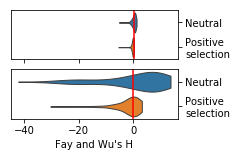

In [10]:
metric = "fay_and_wus_H"
xlabel = "Fay and Wu's H"

fig, axes = plt.subplots(2, 1, figsize=(3,2), sharex=True)

for ax, T, F_kingman, F_bsc in zip(axes, F_empirical.trees, J_kingman, J_bsc):
    data = [getattr(F_kingman, metric)(), getattr(F_bsc, metric)()]
    sns.violinplot(data=data, ax=ax, orient="h", cut=0, inner=None, scale="width", linewidth=1)
    v = getattr(T, metric)()
    ax.axvline(v, color="r")
    ax.set_yticklabels(["Neutral", "Positive\nselection"])
    ax.yaxis.tick_right()

axes[-1].set_xlabel(xlabel)

Text(0.5,0,"Zeng's E")

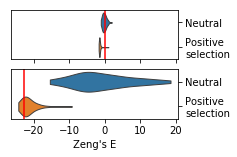

In [11]:
metric = "zengs_E"
xlabel = "Zeng's E"

fig, axes = plt.subplots(2, 1, figsize=(3,2), sharex=True)

for ax, T, F_kingman, F_bsc in zip(axes, F_empirical.trees, J_kingman, J_bsc):
    data = [getattr(F_kingman, metric)(), getattr(F_bsc, metric)()]
    sns.violinplot(data=data, ax=ax, orient="h", cut=0, inner=None, scale="width", linewidth=1)
    v = getattr(T, metric)()
    ax.axvline(v, color="r")
    ax.set_yticklabels(["Neutral", "Positive\nselection"])
    ax.yaxis.tick_right()

axes[-1].set_xlabel(xlabel)

Text(0.5,0,"Tajima's D")

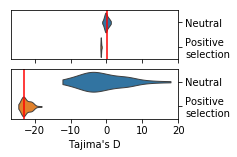

In [12]:
metric = "tajimas_D"
xlabel = "Tajima's D"

fig, axes = plt.subplots(2, 1, figsize=(3,2), sharex=True)

for ax, T, F_kingman, F_bsc in zip(axes, F_empirical.trees, J_kingman, J_bsc):
    data = [getattr(F_kingman, metric)(), getattr(F_bsc, metric)()]
    sns.violinplot(data=data, ax=ax, orient="h", cut=0, inner=None, scale="width", linewidth=1)
    v = getattr(T, metric)()
    ax.axvline(v, color="r")
    ax.set_yticklabels(["Neutral", "Positive\nselection"])
    ax.yaxis.tick_right()

axes[-1].set_xlabel(xlabel)

Text(0.5,0,"Ferretti's L")

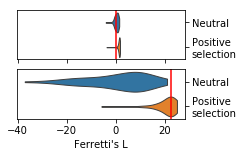

In [13]:
metric = "ferrettis_L"
xlabel = "Ferretti's L"

fig, axes = plt.subplots(2, 1, figsize=(3,2), sharex=True)

for ax, T, F_kingman, F_bsc in zip(axes, F_empirical.trees, J_kingman, J_bsc):
    data = [getattr(F_kingman, metric)(), getattr(F_bsc, metric)()]
    sns.violinplot(data=data, ax=ax, orient="h", cut=0, inner=None, scale="width", linewidth=1)
    v = getattr(T, metric)()
    ax.axvline(v, color="r")
    ax.set_yticklabels(["Neutral", "Positive\nselection"])
    ax.yaxis.tick_right()

axes[-1].set_xlabel(xlabel)

# Calculate statistical support for models

In [14]:
# Report P values

for i, (T_empirical, F_kingman, F_bsc) in enumerate(zip(F_empirical.trees, J_kingman, J_bsc)):
        
    for attr in ["_fay_and_wus_H", "_zengs_E", "_tajimas_D", "_ferrettis_L"]:

        p_kingman = F_kingman.p_metric(attr=attr, model=scipy.stats.norm, value=getattr(T_empirical, attr))
        p_bsc = F_bsc.p_metric(attr=attr, model=scipy.stats.norm, value=getattr(T_empirical, attr))

        if attr == "_ferrettis_L":
            # For Ferretti's L, calculate P value of being right of the distribution
            p_kingman = 1 - p_kingman
            p_bsc = 1 - p_bsc
        
        ll_bsc_kingman = np.log10(p_bsc/p_kingman) # log-likelihood ratio
        
        print attr
        print "P_kingman", p_kingman
        print "P_bsc", p_bsc
        print "Log-likelihood ratio", ll_bsc_kingman
        print
    
    print "#############################################################################"
    print

_fay_and_wus_H
P_kingman 0.4827557461801631
P_bsc 0.7128462099859012
Log-likelihood ratio 0.1692683930827578

_zengs_E
P_kingman 0.6008305101011807
P_bsc 0.9999998437347841
Log-likelihood ratio 0.22124795415714835

_tajimas_D
P_kingman 0.5942511707768653
P_bsc 1.0
Log-likelihood ratio 0.22602995396422257

_ferrettis_L
P_kingman 0.5761525238759136
P_bsc 0.9869078822233205
Log-likelihood ratio 0.23373914892267597

#############################################################################

_fay_and_wus_H
P_kingman 0.4961563769434098
P_bsc 0.639647051006398
Log-likelihood ratio 0.11032182440080282

_zengs_E
P_kingman 0.0034317389506236186
P_bsc 0.2902672314855934
Log-likelihood ratio 1.927283766693521

_tajimas_D
P_kingman 0.000325728905894494
P_bsc 0.35962021098151964
Log-likelihood ratio 3.042987790974393

_ferrettis_L
P_kingman 0.0438068004137071
P_bsc 0.32001222618753244
Log-likelihood ratio 0.8636250369347144

########################################################################